In [2]:
!gpustat

NucleusC112               Sun Nov 17 20:16:09 2024  550.54.14
[0] NVIDIA A100-SXM4-80GB | 31°C,  28 % | 34124 / 81920 MB | s230873(1090M) s229001(5112M) s229001(5112M) s439850(3038M) s229001(16962M) s439850(2764M)
[1] NVIDIA A100-SXM4-80GB | 31°C,   0 % | 47740 / 81920 MB | s439850(2792M) s439850(10704M) s439850(27312M) s211453(6902M)
[2] NVIDIA A100-SXM4-80GB | 31°C,  24 % | 32112 / 81920 MB | s229001(2516M) s229001(4254M) s229001(3294M) s439850(3396M) s439850(2792M) s211453(6882M) s439850(8930M)
[3] NVIDIA A100-SXM4-80GB | 33°C,  23 % | 62694 / 81920 MB | s229001(880M) s229001(6216M) s439850(2720M) s439850(11354M) s439850(11364M) s211453(720M) s439850(1016M) s211453(7644M) s439850(20718M)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
import pyensembl
ensembl = pyensembl.EnsemblRelease(104)
# ensembl.download()

## Load dataset

In [5]:
# load json data
import json
with open('/archive/bioinformatics/Zhou_lab/shared/jjin/project/pan_cancer_α_KG_dependent_analysis/datasets/TCGA_cancer_type_mapping.json') as f:
    cancer_name_to_id = json.load(f)

In [6]:
#get cancer id to name
cancer_id_to_name = {v: k for k, v in cancer_name_to_id.items()}

In [7]:
original_data = pd.read_csv('/archive/bioinformatics/Zhou_lab/shared/jjin/project/pan_cancer_α_KG_dependent_analysis/datasets/TCGA_dataset.csv')

In [8]:
#original_data = original_data.drop(original_data.columns[0], axis=1)
gene_name_list = []
for i in tqdm(range(len(original_data.columns))):
    if original_data.columns.values[i].startswith('ENSG'):
        original_data.columns.values[i] = ensembl.gene_by_id(original_data.columns[i].split('.')[0]).gene_name
        gene_name_list.append(original_data.columns.values[i])
original_data = original_data.dropna()

100%|██████████| 69/69 [00:00<00:00, 921.88it/s]


In [9]:
len(gene_name_list)

64

In [10]:
gene2id = {gene: idx for idx, gene in enumerate(gene_name_list)}

In [11]:
num_cancers = len(original_data['cancer_type_int'].unique())

## Define GeneExpressionDataset

In [12]:
class GeneExpressionDataset(Dataset):
    def __init__(self, gene_ids, cancer_ids, labels):
        self.gene_ids = torch.tensor(gene_ids, dtype=torch.float)
        self.cancer_ids = torch.tensor(cancer_ids, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'gene_ids': self.gene_ids[idx],
            'cancer_ids': self.cancer_ids[idx],
            'labels': self.labels[idx]
        }

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_df, val_df = train_test_split(original_data, test_size=0.2, random_state=42, stratify=original_data['OS'])

# prepare train and val data
train_gene_expression = scaler.fit_transform(train_df[gene_name_list].values.astype(float))
train_cancer_ids = train_df['cancer_type_int'].values.astype(float)
train_labels = train_df['OS'].values.astype(int)

val_gene_expression = scaler.transform(val_df[gene_name_list].values.astype(float))
val_cancer_ids = val_df['cancer_type_int'].values.astype(float)
val_labels = val_df['OS'].values.astype(int)

# prepare datasets and dataloaders
train_dataset = GeneExpressionDataset(train_gene_expression, train_cancer_ids, train_labels)
val_dataset = GeneExpressionDataset(val_gene_expression, val_cancer_ids, val_labels)

# prepare dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define model

In [14]:
class IndividualFloatEmbedding(nn.Module):
    def __init__(self, num_features=64, embedding_dim=128):
        super(IndividualFloatEmbedding, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, embedding_dim),
                nn.ReLU(),
                nn.Linear(embedding_dim, embedding_dim)
            ) for _ in range(num_features)
        ])

    def forward(self, x):
        embedded_features = [
            embedding(x[:, i:i+1]) for i, embedding in enumerate(self.embeddings)
        ]

        return torch.stack(embedded_features, dim=1)

class panCancerModel(nn.Module):
    def __init__(self, batch_size=8, num_genes=64, num_cancers=10, input_dim=64, embedding_dim=128, output_dim=2, hidden_dim=256, num_layers=2, num_heads=4):
        super(panCancerModel, self).__init__()
        self.batch_size = batch_size
        self.num_genes = num_genes
        self.num_cancers = num_cancers
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # define embeddings
        self.cancer_embedding = nn.Embedding(num_cancers, embedding_dim)
        self.gene_embedding = IndividualFloatEmbedding(num_genes, embedding_dim)
        
        # define transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(embedding_dim, output_dim)

        )
        # [CLS] token for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))

    def forward(self, gene_ids, cancer_ids):
        gene_embeds = self.gene_embedding(gene_ids)  # (batch_size, seq_len, embedding_dim)
        cancer_embeds = self.cancer_embedding(cancer_ids).unsqueeze(1)  # (batch_size, 1,embedding_dim)

        cls_token = self.cls_token + cancer_embeds  # (batch_size, 1, embedding_dim)
        token_embeds = torch.cat([cls_token, gene_embeds], dim=1)

        embeddings = token_embeds.transpose(0, 1)  # (seq_len + 1, batch_size, embedding_dim)
        
        transformer_output = self.transformer_encoder(embeddings)  # (seq_len + 1, batch_size, embedding_dim)
        
        cls_output = transformer_output[0, :, :]  # (batch_size, embedding_dim)
        
        logits = self.classifier(cls_output)

        return logits

## Test model

In [15]:
# Test model
batch_size = 8
seq_len = 64  
 

gene_ids = torch.randn(batch_size, seq_len)
cancer_ids = torch.randint(0, num_cancers, (batch_size,))
print(gene_ids.size())
print(cancer_ids.size())

# create model
model = panCancerModel(num_cancers=num_cancers, num_genes=seq_len)

outputs = model(gene_ids, cancer_ids)

torch.Size([8, 64])
torch.Size([8])


/archive/bioinformatics/Zhou_lab/shared/jjin/software/anaconda3/envs/pancancer/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [16]:
import random


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed = 99
set_seed(seed)

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean', eps=1e-6):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, inputs, targets):
        # transform targets to one-hot
        probs = F.softmax(inputs, dim=1)
        targets = targets.view(-1, 1)
        probs = probs.gather(1, targets)
        probs = probs.squeeze(1)
        probs = probs.clamp(min=self.eps, max=1 - self.eps)

        # compute loss
        log_p = probs.log()
        loss = -self.alpha * (1 - probs) ** self.gamma * log_p

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# calculate the number of positive and negative samples
pos_samples = (train_labels == 1).sum()
neg_samples = (train_labels == 0).sum()
total_samples = len(train_labels)
pos_weight = pos_samples / total_samples
neg_weight = neg_samples / total_samples

## Train the model

In [19]:
model = panCancerModel(num_cancers=num_cancers)

In [20]:
# set the weight of positive samples to the weight of negative samples
alpha = neg_weight.item()

# use focal loss
criterion = FocalLoss(alpha=alpha, gamma=2, reduction='mean')
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
best_val_auc = 0.0
best_model_path = '/archive/bioinformatics/Zhou_lab/shared/jjin/project/pan_cancer_α_KG_dependent_analysis/saves/TCGA_best_model_1.pth'
train_auc_list = []
val_auc_list = []

# set training epoch
num_epochs = 50

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        gene_ids = batch['gene_ids']
        cancer_ids = batch['cancer_ids']
        labels = batch['labels']
        
        if torch.cuda.is_available():
            gene_ids = gene_ids.cuda()
            cancer_ids = cancer_ids.cuda()
            labels = labels.cuda()
        
        outputs = model(gene_ids, cancer_ids)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # validation
    model.eval()
    val_labels_all = []
    val_probs_all = []
    cancer_type_metrics = {}
    
    with torch.no_grad():
        for batch in val_loader:
            gene_ids = batch['gene_ids']
            cancer_ids = batch['cancer_ids']
            labels = batch['labels']
            
            if torch.cuda.is_available():
                gene_ids = gene_ids.cuda()
                cancer_ids = cancer_ids.cuda()
                labels = labels.cuda()
            
            outputs = model(gene_ids, cancer_ids)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            predicted = torch.argmax(outputs, dim=1)
            
            labels_np = labels.cpu().numpy()
            probs_np = probs.cpu().numpy()
            predicted_np = predicted.cpu().numpy()
            cancer_ids_np = cancer_ids.cpu().numpy()
            
            val_labels_all.extend(labels_np)
            val_probs_all.extend(probs_np)
            
            for i in range(len(labels_np)):
                cancer_id = cancer_ids_np[i]
                label = labels_np[i]
                prob = probs_np[i]
                pred = predicted_np[i]
                
                if cancer_id not in cancer_type_metrics:
                    cancer_type_metrics[cancer_id] = {
                        'labels': [],
                        'probs': [],
                        'preds': []
                    }
                cancer_type_metrics[cancer_id]['labels'].append(label)
                cancer_type_metrics[cancer_id]['probs'].append(prob)
                cancer_type_metrics[cancer_id]['preds'].append(pred)
    
    # calculate AUC for all cancer types
    val_auc = roc_auc_score(val_labels_all, val_probs_all)
    val_auc_list.append(val_auc)
    print(f'Validation AUC: {val_auc:.4f}')
    
    # if the AUC is the best, save the model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model saved with AUC: {best_val_auc:.4f}')

Epoch [1/50], Loss: 0.0992
Validation AUC: 0.7329
New best model saved with AUC: 0.7329
Epoch [2/50], Loss: 0.0965
Validation AUC: 0.7480
New best model saved with AUC: 0.7480
Epoch [3/50], Loss: 0.0957
Validation AUC: 0.7437
Epoch [4/50], Loss: 0.0958
Validation AUC: 0.7469
Epoch [5/50], Loss: 0.0954
Validation AUC: 0.7492
New best model saved with AUC: 0.7492
Epoch [6/50], Loss: 0.0952
Validation AUC: 0.7511
New best model saved with AUC: 0.7511
Epoch [7/50], Loss: 0.0950
Validation AUC: 0.7514
New best model saved with AUC: 0.7514
Epoch [8/50], Loss: 0.0953
Validation AUC: 0.7528
New best model saved with AUC: 0.7528
Epoch [9/50], Loss: 0.0951
Validation AUC: 0.7525
Epoch [10/50], Loss: 0.0951
Validation AUC: 0.7520
Epoch [11/50], Loss: 0.0946
Validation AUC: 0.7564
New best model saved with AUC: 0.7564
Epoch [12/50], Loss: 0.0948
Validation AUC: 0.7579
New best model saved with AUC: 0.7579
Epoch [13/50], Loss: 0.0944
Validation AUC: 0.7548
Epoch [14/50], Loss: 0.0945
Validation AUC

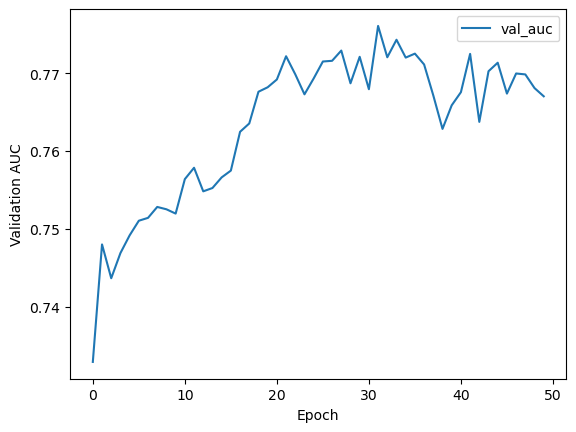

In [22]:
plt.plot(val_auc_list, label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.legend()
plt.show()

In [24]:
# load best model
best_model_path = '/archive/bioinformatics/Zhou_lab/shared/jjin/project/pan_cancer_α_KG_dependent_analysis/saves/TCGA_best_model.pth'
model.load_state_dict(torch.load(best_model_path))

/tmp/ipykernel_36299/1541374076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

## Captum analysis

In [25]:
def forward_func(gene_ids, cancer_ids):
    gene_embeds = model.gene_embedding(gene_ids)  # (batch_size, seq_len, embedding_dim)
    cancer_embeds = model.cancer_embedding(cancer_ids).unsqueeze(1)  # (batch_size, 1, embedding_dim)

    cls_token = model.cls_token + cancer_embeds  # (batch_size, 1, embedding_dim)
    token_embeds = torch.cat([cls_token, gene_embeds], dim=1)
    
    embeddings = token_embeds.transpose(0, 1)  # (seq_len + 1, batch_size, embedding_dim)
    transformer_output = model.transformer_encoder(embeddings)  # (seq_len + 1, batch_size, embedding_dim)
        
    cls_output = transformer_output[0, :, :]  # (batch_size, embedding_dim) 
    logits = model.classifier(cls_output)
    probs = torch.softmax(logits, dim=1)[:, 1]
    
    return probs


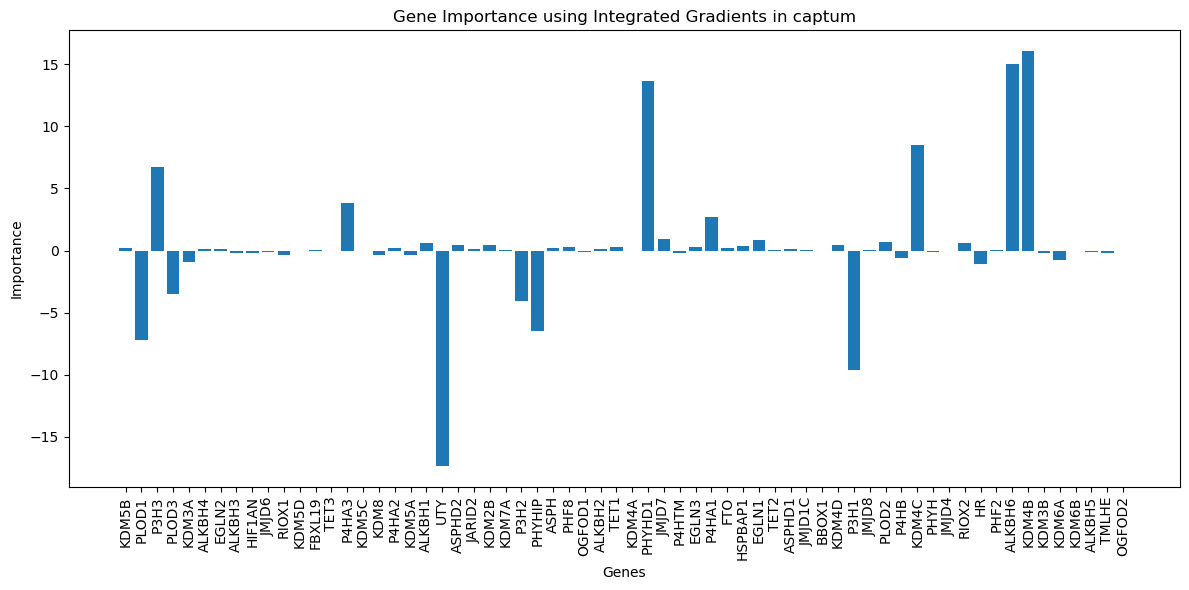

In [26]:
from captum.attr import LayerIntegratedGradients, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

model.eval()
def compute_gene_expression_mean(train_dataset):
    total = torch.zeros(64)
    count = 0
    for sample in train_dataset:
        total += sample['gene_ids'].sum(dim=0)
        count += sample['gene_ids'].size(0)
    return total / count

lig = LayerIntegratedGradients(forward_func, model.gene_embedding)

# initialize gene importance
gene_importances = torch.zeros(64)

target_dataset = [sample for sample in val_dataset]
target_loader = DataLoader(target_dataset, batch_size=1)

gene_expression_mean = compute_gene_expression_mean(train_dataset)
for batch in target_loader:
    gene_ids = batch['gene_ids']  # (1, seq_len)
    cancer_ids = batch['cancer_ids']  # (1,)
    labels = batch['labels']  # (1,)
    
    if torch.cuda.is_available():
        gene_ids = gene_ids.cuda()
        cancer_ids = cancer_ids.cuda()
        labels = labels.cuda()
    
    baseline_level_ids = gene_expression_mean.unsqueeze(0).repeat(gene_ids.size(0), 1).to(gene_ids.device)

    # compute attributions
    attributions, delta = lig.attribute(
        inputs=(gene_ids, cancer_ids),
        baselines=(baseline_level_ids, cancer_ids),
        #target=labels,
        return_convergence_delta=True
    )

    #print(attributions[0].shape)
    gene_attr = attributions[0].sum(dim=1).squeeze(0)  # (seq_len,)

    gene_importances += gene_attr.cpu().detach()

id2gene = {idx: gene for gene, idx in gene2id.items()}
gene_names = [id2gene[i] for i in range(64)]

importances = gene_importances.numpy()

# visualize gene importance
plt.figure(figsize=(12, 6))
plt.bar(range(64), importances)
plt.xticks(range(64), gene_names, rotation='vertical')
plt.xlabel('Genes')
plt.ylabel('Importance')
plt.title(f'Gene Importance using Integrated Gradients in captum')
plt.tight_layout()
plt.show()



# SHAP analysis

Input data shape: (2166, 65)


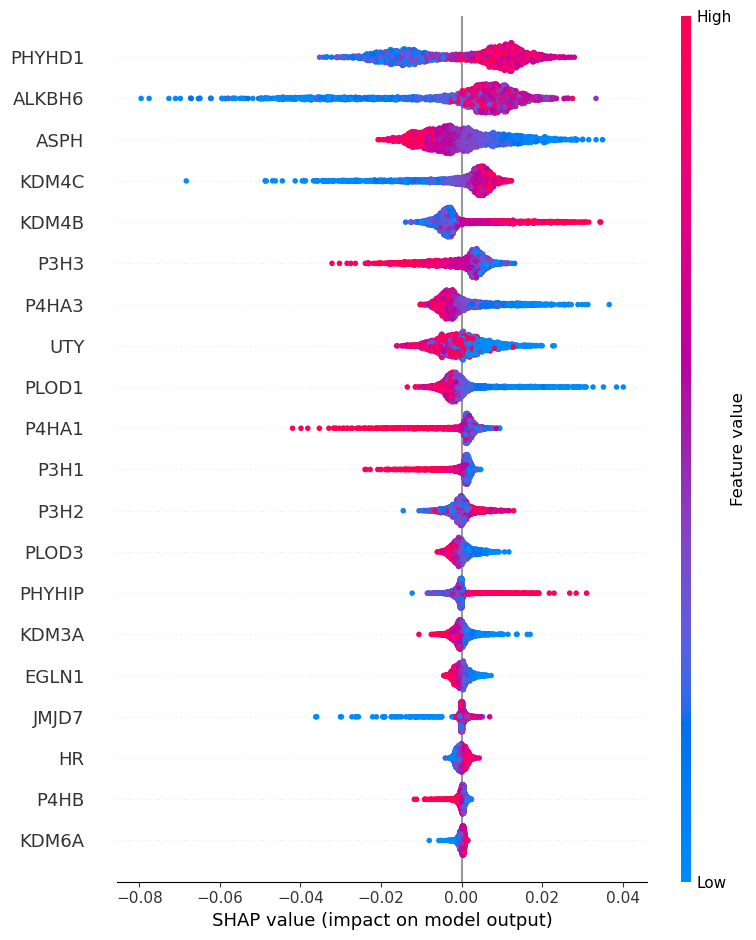

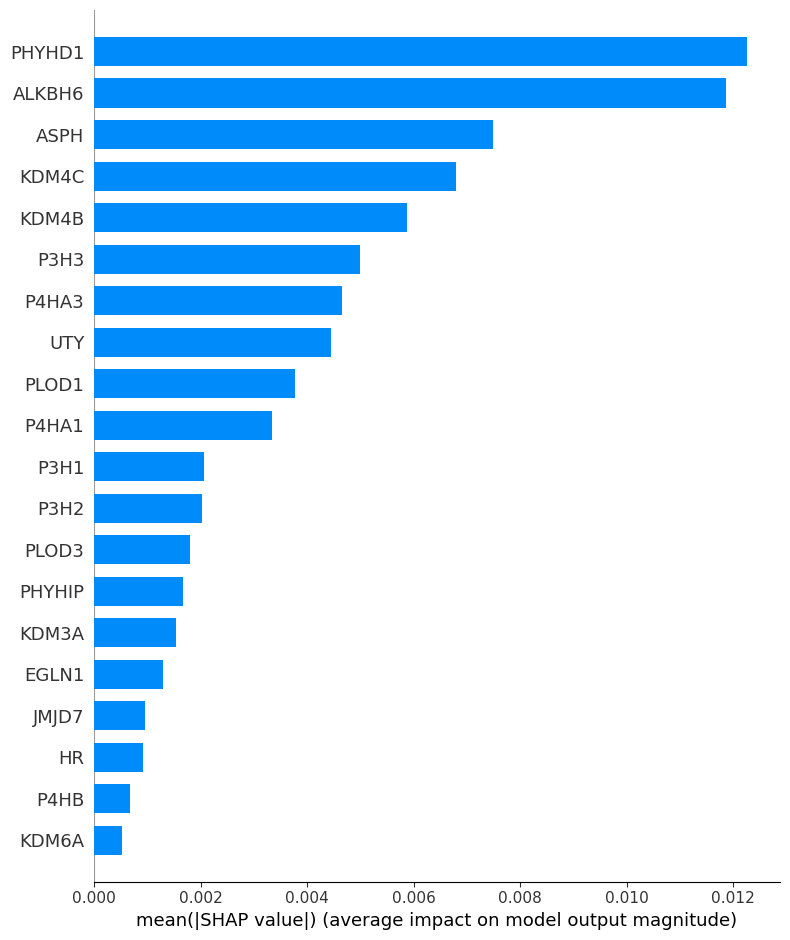

In [27]:
import shap

target_dataset = [sample for sample in val_dataset]
target_loader = DataLoader(target_dataset, batch_size=1)

class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, inputs):
        gene_ids = inputs[:, :64].float()
        cancer_ids = inputs[:, 64].long()
        outputs = self.model(gene_ids, cancer_ids)
        probs = torch.softmax(outputs, dim=1)
        return probs

wrapped_model = WrappedModel(model).cuda()
wrapped_model.eval()

input_data = []
for sample in target_dataset:
    gene_ids = sample['gene_ids'].numpy()
    cancer_id = sample['cancer_ids'].item()
    input_sample = np.concatenate([gene_ids, [cancer_id]])
    input_data.append(input_sample)

input_data = np.array(input_data)  # (num_samples, 65)
print("Input data shape:", input_data.shape)

# create SHAP explainer
input_tensor = torch.tensor(input_data).float().cuda()
explainer = shap.GradientExplainer(wrapped_model, input_tensor)

# compute SHAP values
shap_values = explainer.shap_values(input_tensor)

# visualize SHAP values
id2gene = {idx: gene for gene, idx in gene2id.items()}
gene_names = [id2gene[i] for i in range(64)] + ['cancer_type']

mean_abs_shap_values = np.mean(np.abs(shap_values[:, :, 0]), axis=0)

shap.summary_plot(shap_values[:, :, 0], input_data, feature_names=np.array(gene_names))
shap.summary_plot(shap_values[:, :, 0], input_data, feature_names=np.array(gene_names), plot_type='bar')